In [157]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm

# *Simple univariate example of a normalizing flow*

*Problem description*

Consider the target variable X to be defined as : $$X\sim \mathcal{N}(\mu_X ; \sigma_X)$$ with parameters $$ \mu_X \text{ and } \sigma_X \text{fixed but unknown.} $$ We will use a transformation such that $$ T(u)  = A.u + b $$


In [158]:
#The true values unkown to the simulator
mu_x = 3
sigma_x = 0.5
N = 1000
N_test = 10*N
def gen_observations(number_of_observations:int):
    """Generates a tensor of observations, i.e. x drawn from a normal distribution having mu=mu_x and sigma=sigma_x

    Args:
        number_of_observations (int): Number of obs to generates

    Returns:
        torch.tensor : Tensor of observations
    """

    # Number of sample 
  
    #Generating observations from the true distribution
    X_np = np.random.normal(mu_x,sigma_x,number_of_observations)
    X = torch.from_numpy(X_np)
    X.size()[0]

    X = X.reshape(X.size()[0] , 1)
    X = X.type(torch.float32)
    return X


X=gen_observations(N)
X_test = gen_observations(N_test)

In [159]:
class T(nn.Module):
    """Transformation T(u) = A.u + b

    Args:
        None
    """
    
    def __init__(self):
        """Init with a single linear layer, with bias
        """
        super(T, self).__init__()
        self.b = nn.Parameter(torch.FloatTensor(1).uniform_(-1 , 1))
        self.alpha = nn.Parameter(torch.FloatTensor(1).uniform_(-1, 1 ))
       # self.net = nn.Linear(1, 1) #? Voir ce pb de positif ... idée : utiliser w=exp()
    
    def forward(self,u:torch.tensor):
        """Compute the linear transformation

        Args:
            u (torch.tensor)

        Returns:
            A*u + b
        """
        A = torch.exp(self.alpha)
        return A * u + self.b
    
    def L(self, x):
        """Compute the loss as -log(p_est(x))
        """
        A, b = torch.exp(self.alpha), self.b
    
        res = torch.distributions.normal.Normal(b, A).log_prob(x)
        return - res

In [160]:
n_iter = 200 #Number of iteration
transformation = T() #Instanciation
learning_rate = 1e-1
optimizer = torch.optim.SGD(transformation.parameters(), learning_rate)
#optimizer = torch.optim.Adam(transformation.parameters(), learning_rate)

In [161]:
#Training 
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation.L(X).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation.alpha).item(), transformation.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [162]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1] 

sample_mean = torch.mean(X)
sample_sigma = torch.std(X, unbiased=True)

print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 2.9991743564605713 and b_hat =  2.999174118041992
 Sample std = 0.49011653661727905 and A_hat =  0.48987144231796265
 Final loss =  0.7053261995315552


As expected, the estimated expectation (resp. standard deviation) converges to the sample expectation (resp. standard deviation)

# Visualisation

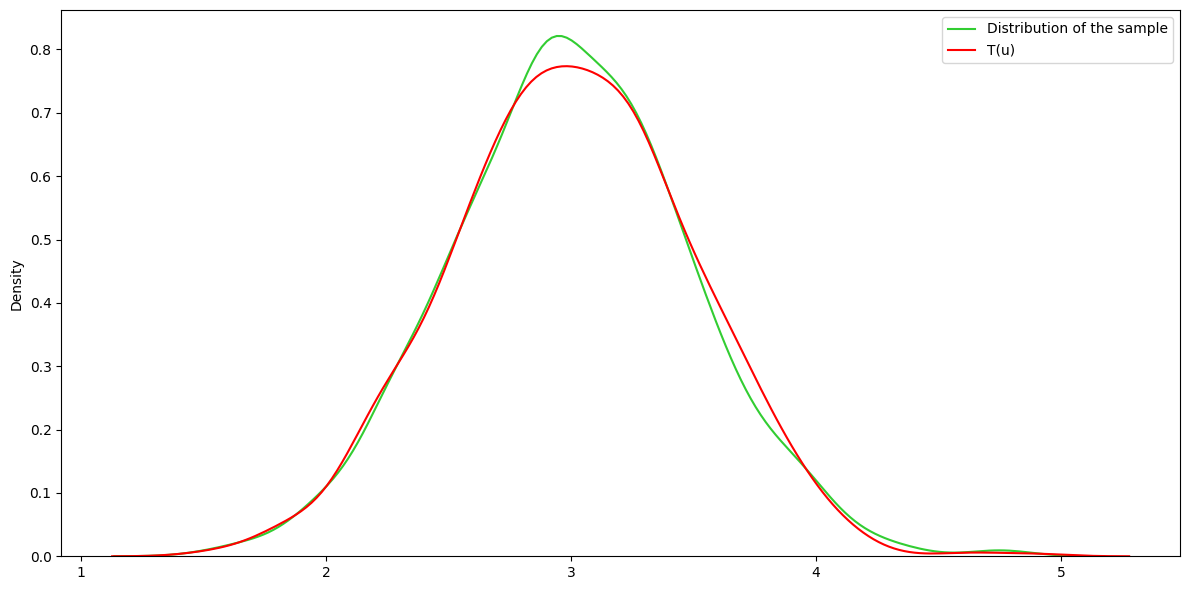

In [163]:
U = torch.distributions.Normal(0, 1).sample((N,1)) # True std Gaussian
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()

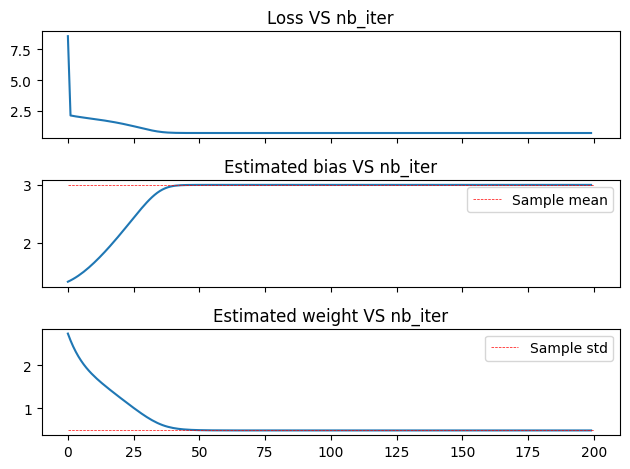

In [164]:
fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(losses)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_b)
axs[1].hlines(y=sample_mean,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample mean", linestyles='dashed')
axs[1].legend()
axs[1].set_title("Estimated bias VS nb_iter")
axs[2].plot(estimated_A)
axs[2].hlines(y=sample_sigma,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Sample std", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated weight VS nb_iter")
fig.tight_layout()

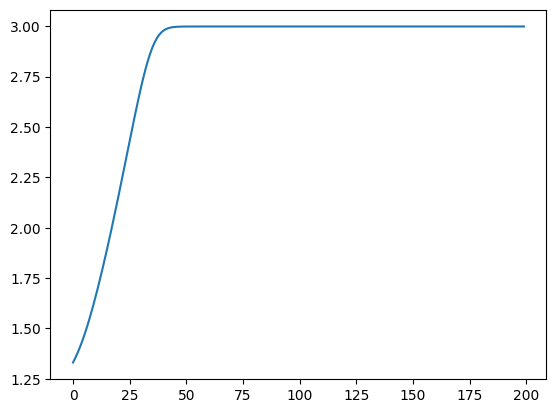

In [165]:
plt.plot(estimated_b)

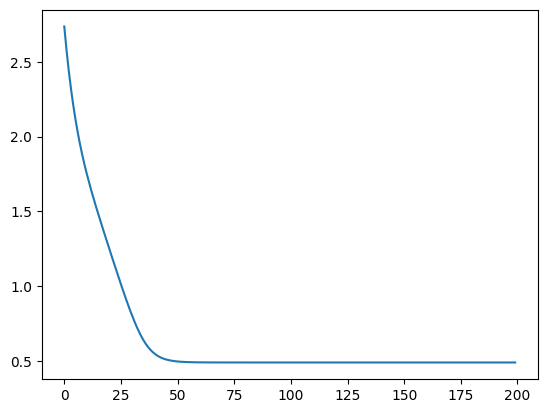

In [166]:
plt.plot(estimated_A)

### Let us compute the loss on a training set

In [167]:
with torch.no_grad():
    loss_t = transformation.L(X_test).mean()
print(loss_t)
losses[-1] # Pas grande différence avec la final loss sur le train

tensor(0.7246)


0.7053261995315552

## Effect of sample size

In [168]:
estimated_A = []
estimated_b = []
sample_sizes = []
n_iter = 200
last_losses = []
sample_means = []
sample_sigmas = []
for sample_size in tqdm(range(10,1000,20)):
    sample_sizes.append(sample_size)
    X = gen_observations(sample_size)
    transformation = T()
    optimizer = torch.optim.SGD(transformation.parameters(),learning_rate)
    #training 
    for i in range(n_iter):
        #Loss
        loss = transformation.L(X).mean()
        #optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    last_losses.append(loss.detach().numpy().item())
    A_hat, b_hat = torch.exp(transformation.alpha).item(), transformation.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)
    sample_mean = torch.mean(X)
    sample_sigma = torch.std(X, unbiased=True)
    sample_means.append(sample_mean)
    sample_sigmas.append(sample_sigma)
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [169]:
print(last_losses)
print(np.mean(last_losses))

[0.5146026015281677, 0.6577532291412354, 0.7163781523704529, 0.7571436166763306, 0.6680155992507935, 0.675591230392456, 0.7177870273590088, 0.6570125818252563, 0.7199634909629822, 0.6815032958984375, 0.7007145285606384, 0.6862795352935791, 0.7221933603286743, 0.737302303314209, 0.784619152545929, 0.6678513288497925, 0.677378237247467, 0.6796828508377075, 0.7356694340705872, 0.7528659701347351, 0.7071906924247742, 0.7302446365356445, 0.6870760917663574, 0.7668673396110535, 0.7050336599349976, 0.7378754615783691, 0.7196954488754272, 0.6952996253967285, 0.7066210508346558, 0.7445840835571289, 0.751223623752594, 0.6626403331756592, 0.7323936820030212, 0.7266891598701477, 0.7763160467147827, 0.7600358128547668, 0.7471577525138855, 0.6899024248123169, 0.7437642812728882, 0.7493495345115662, 0.703014612197876, 0.7452811598777771, 0.7081167697906494, 0.7133166790008545, 0.7169309854507446, 0.7065492868423462, 0.7446367144584656, 0.7125514149665833, 0.7215854525566101, 0.7122567892074585]
0.712

In [170]:
dist_b = abs(np.subtract(sample_means, estimated_b))
dist_A = abs(np.subtract(sample_sigmas, estimated_A))

Text(0.5, 1.0, "Distance between weight A and sample std'")

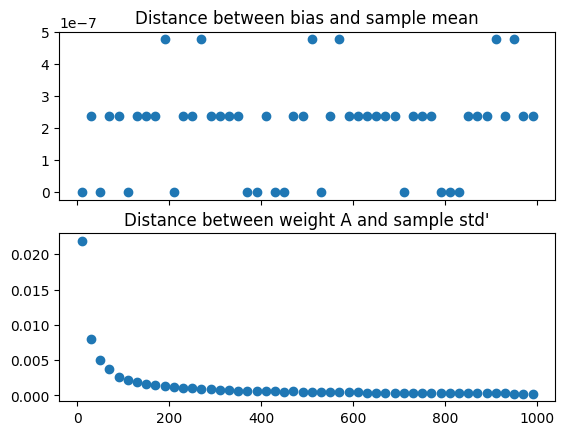

In [171]:
fig, axs = plt.subplots(2, sharex = True)
axs[0].scatter(sample_sizes, dist_b)
#axs[0].set_ylim(-0.5,10)
axs[0].set_title("Distance between bias and sample mean") #Pas très lisible ...
axs[1].scatter(sample_sizes, dist_A)
#axs[1].set_ylim(-0.5,10)
axs[1].set_title("Distance between weight A and sample std'")


## What if if X is not gaussian (here chi2)

In [172]:
X_chi = np.random.chisquare(2, N)
X_chi = torch.from_numpy(X_chi)
X_chi = X_chi.reshape(X_chi.size()[0] , 1)
X_chi = X_chi.type(torch.float32)

In [173]:
transformation2 = T() #Instanciation
optimizer = torch.optim.SGD(transformation2.parameters(), learning_rate)

In [174]:
losses = []
estimated_A = []
estimated_b = []
for i in range(n_iter):
    #Computing & saving the loss
    loss = transformation2.L(X_chi).mean()
    losses.append(loss.detach().numpy().item())
    #optim
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Saving parameters for later vizualisation
    A_hat, b_hat = torch.exp(transformation2.alpha).item(), transformation2.b.item()
    estimated_A.append(A_hat)
    estimated_b.append(b_hat)

In [175]:
A_hat, b_hat = estimated_A[-1], estimated_b[-1]
sample_mean = torch.mean(X_chi)
sample_sigma = torch.std(X_chi, unbiased=True)
print(f" Sample mean = {sample_mean} and b_hat = ", b_hat)
print(f" Sample std = {sample_sigma} and A_hat = ", A_hat)
print(f" Final loss = ", losses[-1])

 Sample mean = 1.8408986330032349 and b_hat =  1.8369494676589966
 Sample std = 1.8263438940048218 and A_hat =  1.8254365921020508
 Final loss =  2.020756721496582


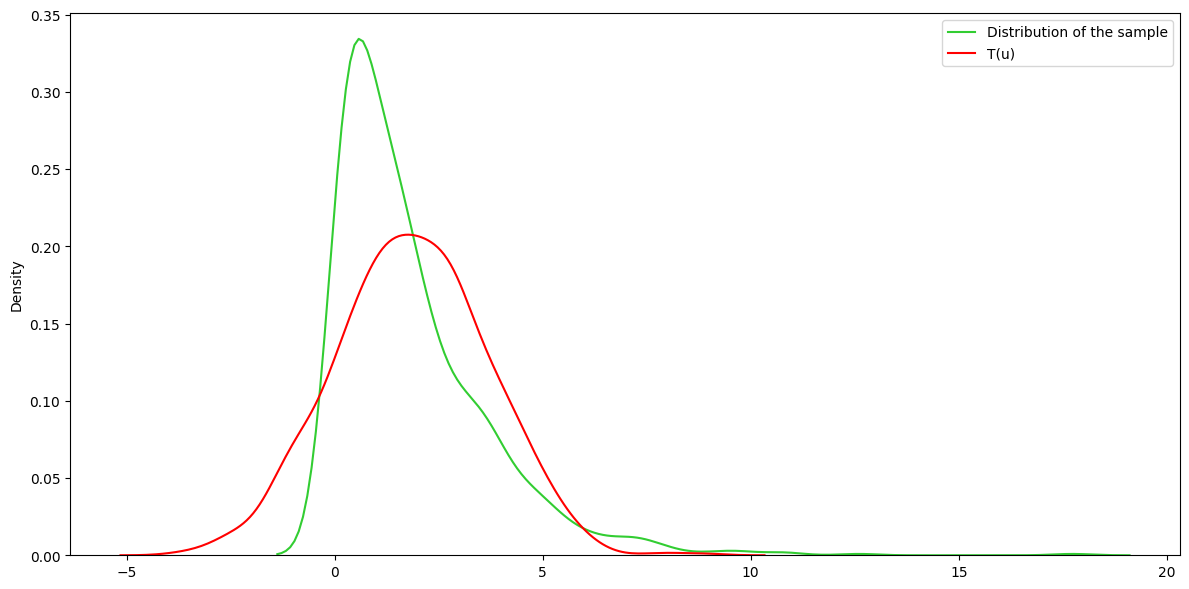

In [176]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=X_chi.squeeze(),
            label='Distribution of the sample', ax=ax, color='limegreen')
sns.kdeplot(data= transformation2.forward(U).detach().squeeze(), ax = ax, color='red', label='T(u)')
ax.legend()
plt.tight_layout()
plt.show()